# Дисбаланс выборки данных
*Несбалансированный набор данных (unbalanced dataset)* — это выборка, в которой количества примеров каждого из классов значительно отличаются.

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn.linear_model import LogisticRegression #логические модели
plt.style.use('seaborn') #стиль отрисовки seaborn
%matplotlib inline

C:\Users\Павел\AppData\Local\Temp\ipykernel_16372\3061251282.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #стиль отрисовки seaborn


0    0.60989
1    0.39011
Name: Potability, dtype: float64

<AxesSubplot: xlabel='Potability', ylabel='count'>

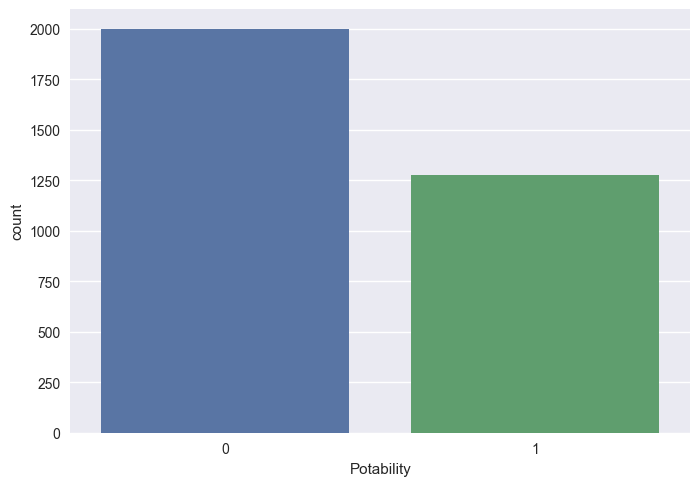

In [2]:
water_data = pd.read_csv('../data/water_potability.csv')
display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data= water_data, x='Potability')

In [3]:
# Заполним пропуски медианным значением
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

# Стратифицированное разбиение
>Для того чтобы снизить влияние дисбаланса классов при разбиении выборки, в наборе данных используется специальный тип разбиения, который называется стратифицированным (stratified). Данное разбиение предполагает, что наблюдения, принадлежащие каждому из классов, гарантированно попадут в каждый из наборов данных в одинаковой пропорции.

In [36]:
# Сначало разобъем данные при помоши hold-out
X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print(f'Train: \n{y_train.value_counts(normalize=True)},sep=''')
print(f'Test: \n{y_test.value_counts(normalize=True)},sep=''')

Train: 
0    0.620229
1    0.379771
Name: Potability, dtype: float64,sep=
Test: 
0    0.568598
1    0.431402
Name: Potability, dtype: float64,sep=


Мы видим, что соотношения классов в тренировочной выборке — 62/38, а в тестовой — 57/43. Давайте попробуем сбалансировать соотношения.

>Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец с правильными ответами y.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Test:\n', y_test.value_counts(normalize=True), sep='')

Train:
0    0.609924
1    0.390076
Name: Potability, dtype: float64
Test:
0    0.609756
1    0.390244
Name: Potability, dtype: float64


А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?

Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и валидационных фолдах соотношения классов были приблизительно одинаковыми.

In [6]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[test_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Test:\n', y_test.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Test:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Test:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------
Train:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
Test:
0    0.60989
1    0.39011
Name: Potability, dtype: float64
----------------------------------------


In [7]:
# # Task 3.3
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
# y = pd.Series(y)
# sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y);

In [8]:
# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y_valid);

## Выбор метрики в условиях дисбаланаса классов

Давайте на примере посмотрим, насколько важен выбор метрики в случае дисбаланса выборки.

Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на валидационной выборке с помощью функции classification_report().

In [9]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       400
           1       0.81      0.55      0.65       256

    accuracy                           0.77       656
   macro avg       0.78      0.73      0.74       656
weighted avg       0.78      0.77      0.76       656



Из отчёта о метриках классификации видно, что для валидационной выборки метрика accuracy составляет 0.77, что, в принципе, является довольно хорошим результатом. Однако если мы посмотрим на метрики recall и f1-score для каждого из классов в отдельности, мы увидим, что метрики для класса 0 значительно выше, чем метрики для класса 1.

- Precision для класса 1 составляет 0.81, то есть из всех образцов воды, причисленных моделью к классу пригодных для питья, 81 % действительно являются таковыми.
- Recall для класса 1 составляет 0.55, то есть из всех образцов в действительности пригодной для питья воды модель посчитала пригодными лишь 55 %, а остальные 45 % посчитала непригодными.
- $F-1$-мера — среднее гармоническое между precision и recall — составила 0.65 для класса 1 и 0.83 — для класса 0. Разница довольно далека от нуля, а значит построенная нами модель больше контролируется на образцах воды, непригодных для питья, и обладает плохой различающей способностью.


Примечание. Поскольку простая accuracy вызывает сомнения в задачах с сильным дисбалансом, были разработаны специальные метрики, основанные на accuracy: это функционал Каппа Коэна (Cohen’s Kappa) и balanced accuracy. Подробнее о них вы можете прочитать [здесь](https://alexanderdyakonov.wordpress.com/2019/05/31/%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D1%8B-%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0-%D0%B2-%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5-%D0%B1%D0%B8%D0%BD%D0%B0%D1%80%D0%BD/).

In [10]:
# # Task 3.5
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
# y = pd.Series(y)

# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# #Создадим модель
# log_reg_model = LogisticRegression()
# #Обучаем модель на тренировочных данных
# log_reg_model.fit(X_train, y_train)
# #Предсказываем модель на тренировочных данных
# y_train_pred = log_reg_model.predict(X_train)
# y_valid_pred = log_reg_model.predict(X_valid)
# # выведем метрики
# print(metrics.classification_report(y_valid, y_valid_pred))

In [11]:
# # task 3.6
# def plot_probabilities_2d(X, y, model):
#     #Генерируем координатную сетку из всех возможных значений для признаков
#     #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
#     xx1, xx2 = np.meshgrid(
#         np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
#         np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
#     )
#     #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
#     #Объединяем два столбца в таблицу с помощью hstack
#     X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
#     #Предсказываем вероятность для всех точек на координатной сетке
#     #Нам нужна только вероятность класса 1
#     probs = model.predict_proba(X_net)[:, 1]
#     #Переводим столбец из вероятностей в размер координатной сетки
#     probs = probs.reshape(xx1.shape)
#     #Создаём фигуру и координатную плоскость
#     fig, ax = plt.subplots(figsize = (10, 5))
#     #Рисуем тепловую карту вероятностей
#     contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
#     #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
#     bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
#     #Добавляем цветовую панель 
#     colorbar = fig.colorbar(contour)
#     #Накладываем поверх тепловой карты диаграмму рассеяния
#     sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
#     #Даём графику название
#     ax.set_title('Scatter Plot with Decision Boundary');
#     #Смещаем легенду в верхний левый угол вне графика
#     ax.legend(bbox_to_anchor=(-0.05, 1))


# plot_probabilities_2d(X, y, log_reg_model)

## Построение модели в условиях дисбаланса классов

Существует несколько способов уменьшить влияние дисбаланса на обучение модели:

- Взвешивание объектов. В функцию ошибки добавляется штраф, прямо пропорциональный количеству объектов каждого класса. Это очень похоже на регуляризацию, которую мы изучали ранее.
- Выбор порога вероятности. Этот подход мы с вами тоже уже использовали ранее. Он заключается в том, что мы подбираем такой порог вероятности (по умолчанию он равен 0.5 во всех моделях), при котором на валидационной выборке максимизируется целевая метрика (например, -score).
- Сэмплирование (sampling) — перебалансировка выборки искусственным путём:
1) oversampling — искусственное увеличение количества объектов миноритарного класса;
2) undersampling — сокращение количества объектов мажоритарного класса.


>Здесь могут использоваться алгоритмы генерации искусственных данных, такие как NearMiss, SMOTE (Synthetic Minority Oversampling Techniques) и ADASYN (Adaptive Synthetic).

Мы рассмотрим наиболее популярный алгоритм — SMOTE, об остальных можно прочитать [здесь](https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/).

Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить параметр class_weight='balanced'.

Посмотрим на реализацию на примере дерева решений

In [12]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



Так гораздо лучше! Обратите внимание на метрики класса 1: значение  поднялось с 0.65 до 0.69. Это произошло потому, что мы стали чаще находить образцы пригодной для питья воды, за счёт чего recall увеличился с 0.55 до 0.76 (правда, немного упал precision).

Да, метрики для класса 0 стали ниже, и у нас слегка упала метрика accuracy, но таков закон баланса — «чтобы где-то прибыло, надо, чтобы где-то убыло». Пусть в целом картина всё ещё не идеальна, но она заметно улучшилась. Разница метрик между классами значительно сократилась. 

In [13]:
# # Task 3.7
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
# y = pd.Series(y)

# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# #Создадим модель
# log_reg_model = LogisticRegression(class_weight='balanced')
# #Обучаем модель на тренировочных данных
# log_reg_model.fit(X_train, y_train)
# #Предсказываем модель на тренировочных данных
# y_train_pred = log_reg_model.predict(X_train)
# y_valid_pred = log_reg_model.predict(X_valid)
# # выведем метрики
# print(metrics.classification_report(y_valid, y_valid_pred))

### Pr- кривая или выбор порога вероятности

Перед построением PR-кривой нам необходимо предсказать вероятности принадлежности к классу 1 на валидационных фолдах кросс-валидации.

Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции cross_validate().

In [14]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred 

array([[0.        , 1.        ],
       [0.24561404, 0.75438596],
       [1.        , 0.        ],
       ...,
       [0.60621762, 0.39378238],
       [1.        , 0.        ],
       [0.03030303, 0.96969697]])

Это массив из вероятностей для каждого образца воды. Первое число в строке — вероятность того, что данный образец является непригодным для питья, а второе — вероятность того, что данный образец пригоден для питья.

Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим этот столбец из матрицы с вероятностями:

In [15]:
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]


Теперь мы можем построить PR-кривую. Для этого воспользуемся функций *precision_recall_curve()* из модуля metrics библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами пороги вероятности:

In [16]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.02739726 0.02898551 0.05       0.07407407]
Precision scores: [0.39007634 0.50050659 0.50357873 0.50437919 0.5043837 ]
Recall scores: [1.         0.9667319  0.96379648 0.95792564 0.95694716]


Осталось дело за малым. Вычислим значение $F-1$-score при различных порогах вероятности и найдём такой порог вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она возвращает индекс максимального элемента массива.

Далее построим PR-кривую и отметим на ней точку максимума $F-1$-score.

Best threshold = 0.33, F1-Score = 0.69


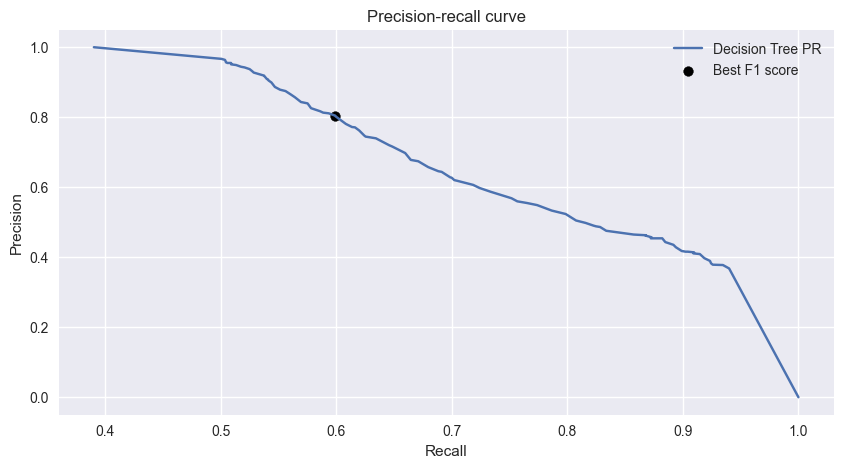

In [17]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();


Итак, согласно нашим вычислениям и построенной PR-кривой, максимум F-1 (0.69) на кросс-валидации наблюдается при пороге вероятности 0.33.

In [18]:
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > thresholds[idx]).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.62      0.76      0.68       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



In [19]:
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

PR AUC: 0.79


### Сэмплирование
Следующий подход работы в условиях дисбаланса классов, который мы рассмотрим, — сэмплирование, а точнее — пересэмплирование (oversampling).

Идея очень проста: если у нас мало наблюдений миноритарного класса, следует искусственно увеличить их количество.
>Простейшая стратегия пересэмплирования — продублировать объекты малого класса. Но это неинтересно и работает довольно плохо. Поэтому были созданы специальные алгоритмы генерации искусственных данных. Самый популярный из таких алгоритмов — алгоритм SMOTE (Synthetic Minority Oversampling Techniques).

In [20]:
from imblearn.over_sampling import SMOTE


Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

In [21]:
sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (2620, 9)
Class balance before oversampling: 
0    1598
1    1022
Name: Potability, dtype: int64
----------------------------------------
Train shape after oversampling: (3196, 9)
Class balance after oversampling: 
0    1598
1    1598
Name: Potability, dtype: int64


Итак, размер выборки увеличился с 2 620 примеров до 3 196, и теперь количество наблюдений каждого из классов одинаково (1 598/1 598).

Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать метрики:

In [22]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76       400
           1       0.63      0.78      0.69       256

    accuracy                           0.73       656
   macro avg       0.73      0.74      0.73       656
weighted avg       0.75      0.73      0.73       656



In [23]:
# # Task 3.11
# from sklearn import datasets
# X, y = datasets.make_classification(
#     n_samples=200, #количество объектов
#     n_features=2, #количество признаков
#     n_informative=2, #количество информативных признаков
#     n_redundant=0, #количество неинформативных признаков
#     n_classes=2, #количество классов
#     weights=[1, 0.2], #пропорции классов
#     random_state=40 #генератор случайных чисел
# )
# X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
# y = pd.Series(y)
# # разобъем данные
# X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# # создадим ресемпл и преобразуем данные
# sm = SMOTE(random_state=42)
# X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

# #Создадим модель
# log_reg_model = LogisticRegression()
# #Обучаем модель на тренировочных данных
# log_reg_model.fit(X_train_s, y_train_s)
# #Предсказываем модель на тренировочных данных
# y_train_pred = log_reg_model.predict(X_train)
# y_valid_pred = log_reg_model.predict(X_valid)
# # выведем метрики
# print(metrics.classification_report(y_valid, y_valid_pred))


In [24]:
# # task 3.12
# def plot_probabilities_2d(X, y, model):
#     #Генерируем координатную сетку из всех возможных значений для признаков
#     #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
#     xx1, xx2 = np.meshgrid(
#         np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
#         np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
#     )
#     #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
#     #Объединяем два столбца в таблицу с помощью hstack
#     X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
#     #Предсказываем вероятность для всех точек на координатной сетке
#     #Нам нужна только вероятность класса 1
#     probs = model.predict_proba(X_net)[:, 1]
#     #Переводим столбец из вероятностей в размер координатной сетки
#     probs = probs.reshape(xx1.shape)
#     #Создаём фигуру и координатную плоскость
#     fig, ax = plt.subplots(figsize = (10, 5))
#     #Рисуем тепловую карту вероятностей
#     contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
#     #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
#     bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
#     #Добавляем цветовую панель 
#     colorbar = fig.colorbar(contour)
#     #Накладываем поверх тепловой карты диаграмму рассеяния
#     sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
#     #Даём графику название
#     ax.set_title('Scatter Plot with Decision Boundary');
#     #Смещаем легенду в верхний левый угол вне графика
#     ax.legend(bbox_to_anchor=(-0.05, 1))


# plot_probabilities_2d(X, y, log_reg_model)

## Недообучение и переобучение. Утечка данных.

Основные способы отследить переобучение:

- hold-out-разбиение,
- k-fold-валидация и leave-one-out-валидация,
- кривые обучения (learning curves)

Рассмотрим пример. Будем использовать тот же набор данных об образцах воды.

Сначала проверим модель на переобучение с помощью отложенной (hold-out) выборки.

Для этого стратифицированно разобьём набор данных на тренировочную и валидационную выборки в соотношении 80/20 и обучим дерево решений с энтропией  в качестве критерия информативности и сбалансированными весами классов без ограничения его глубины и количества объектов в листе. Сделаем предсказание для каждой из выборок и рассчитаем метрику F-1-score:



In [25]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    class_weight='balanced', #веса классов
    random_state=42 #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model_bad.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train F1 score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid F1 score: {:.2f}'.format(metrics.f1_score(y_valid, y_valid_pred)))

Train F1 score: 1.00
Valid F1 score: 0.67


Так как на тестовой выборке и тренировочной результаты сильно отличаются. Это типичная картина переобучения: модель дерева решений полностью адаптировалась под обучающий набор данных, но не нашла общих закономерностей, поэтому результаты на контроле оставляют желать лучшего.

Проверим гипотезу о наличии переобучения у нашего дерева с помощью кросс-валидации k-fold. Организуем стратифицированную кросс-валидацию на пяти фолдах. На каждом шаге кросс-валидации будем вычислять метрику F-1 на тренировочных и валидационных фолдах.

In [26]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model_bad, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.04157567, 0.04079461, 0.04928088, 0.0322516 , 0.03233981]),
 'score_time': array([0.        , 0.00842047, 0.00821567, 0.        , 0.        ]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [27]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


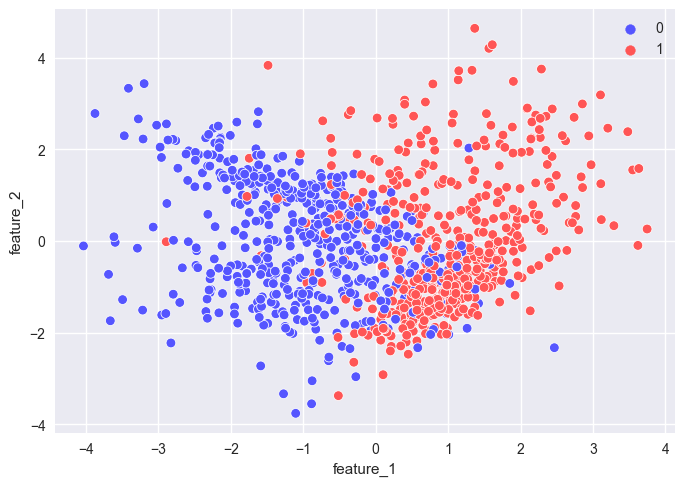

In [28]:
# Task 4.3
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
sns.scatterplot(x=X['feature_1'], y=X['feature_2'], hue=y, palette='seismic');

In [29]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#Создаём модель
model_task = tree.DecisionTreeClassifier(
    max_depth=10
)
#Обучаем модель на тренировочной выборке
model_task.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_task.predict(X_train)
y_valid_pred = model_task.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train accuray score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accuray score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accuray score: 0.98
Valid accuray score: 0.85


c:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


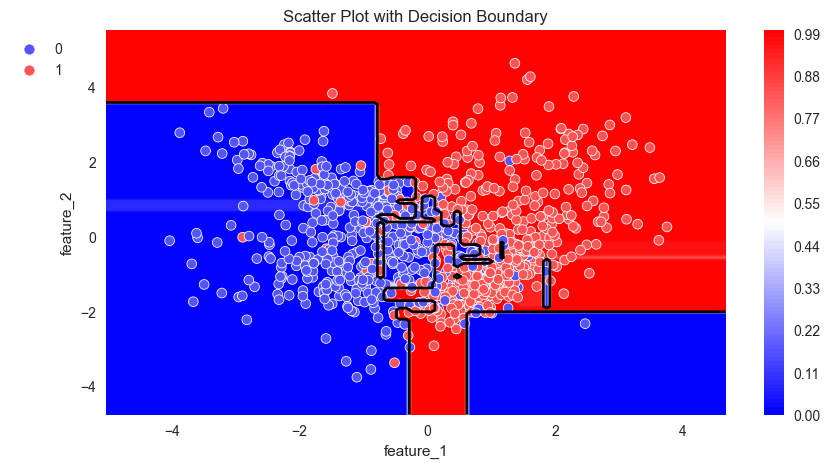

In [30]:
# task 4.4
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))


plot_probabilities_2d(X, y, model_task)

### Методы борьбы с переобучением
1. Уменьшение сложности модели: 
Это основной способ борьбы с переобучением, так как, по сути, повышенная сложность модели и является его причиной.

* 1.1 Для линейной (логистической) регрессии с полиномиальными признаками уменьшение сложности модели означает понижение степени полинома.

* 1.2 Для деревьев решений — «стрижка» (pruning) деревьев, то есть уменьшение их глубины **(max_depth)** и/или увеличение количества объектов, при которых вершина дерева превращается в лист **(min_samples_leaf)**.

* 1.3 Для случайного леса — «стрижка» деревьев **(max_depth и min_samples_leaf)** и уменьшение количества признаков, на которых обучается каждое дерево **(max_features)**.

2. Регуляризация моделей:

С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

3. Манипуляции с данными:
Ещё один верный способ побороть переобучение — увеличить или уменьшить количество примеров, на которых обучается модель.

- Увеличивать набор данных можно за счёт проведения новых экспериментов и сбора новой информации.
- Уменьшать набор данных можно за счёт удаления выбросов и аномалий из обучающего набора данных, из-за которых отчасти и происходит переобучение модели.

Также можно отбирать наиболее значимые признаки, которые в наибольшей степени влияют на предсказания модели.

In [31]:
# Проверим глубину дерева, что бы понять причину
print('Current depth:', model_bad.get_depth())

Current depth: 27


>Дерево глубиной 27 — это очень сложная модель. Давайте попробуем её упростить, добавив в дерево решений ограничение на глубину (max_depth). Пусть максимальная глубина дерева будет равна 7.

In [32]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=5, #ограничиваем глубину дерева
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.89
Valid k-fold mean f1: 0.85


Попробуем добавить ещё одно ограничение к нашему дереву: увеличим количество объектов, которых достаточно для образования листа дерева (min_samples_leaf). По умолчанию этот параметр равен 1. 

>Напомним интерпретацию данного параметра. Пусть min_samples_leaf=5. Допустим, в результате разделения получается две вершины: первая — с четырьмя объектами, а вторая — с шестью. Тогда дерево разрешит снова делиться только второй вершине (6 > min_samples_leaf), а первая вершина (4 < min_samples_leaf) дерева превратится в лист, и её деление будет остановлено.

In [33]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #ограничиваем глубину дерева
    min_samples_leaf=5, #увеличиваем количество объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.91
Valid k-fold mean f1: 0.85


In [34]:
# Task 4.6
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)
#Создаём модель
model_task = tree.DecisionTreeClassifier(
    max_depth=3
)
#Обучаем модель на тренировочной выборке
model_task.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model_task.predict(X_train)
y_valid_pred = model_task.predict(X_valid)
#Выводим значения метрик для тренировочной выборки
print('Train accuray score: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
#Выводим значения метрик для валидационной выборки
print('Valid accuray score: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred)))

Train accuray score: 0.88
Valid accuray score: 0.85


c:\Users\Павел\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


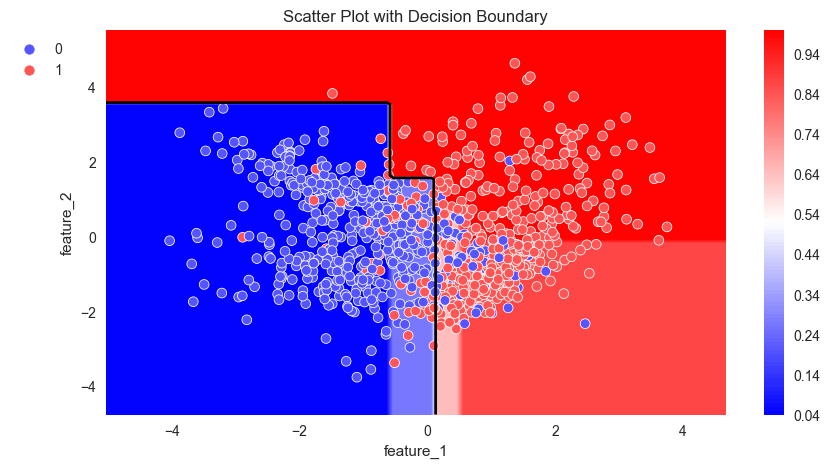

In [35]:
# task 4.7
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))


plot_probabilities_2d(X, y, model_task)

##

### Утечка данных
1. ОЧЕВИДНЫЕ СЛУЧАИ

- Наиболее очевидной ситуацией утечки данных является включение целевой переменной, которую мы пытаемся предсказать, в качестве фактора, что полностью уничтожает цель «прогнозирования». Это может быть сделано по ошибке, но важно убедиться, что целевая переменная отличается от признаков.

- Другой распространённой причиной утечки данных является включение тестовых данных в данные по обучению модели, а затем использование этих же тестовых данных для оценки качества модели.

Два этих случая возникают скорее по невнимательности, и их легко обнаружить. Более опасные причины — скрытые.

2. СКРЫТЫЕ СЛУЧАИ, ИЛИ GIVEAWAY-ПРИЗНАКИ

*Giveaway* — это признаки, которые раскрывают информацию о целевой переменной и не будут доступны после развёртывания модели в реальных условиях. Такие признаки необходимо удалять из данных перед построением модели.

## Кривая обучения learning curve
>Кривая обучения (learning curve) — это график зависимости некоторой метрики на обучающем (валидационном) наборе данных от количества объектов, которые участвуют в обучении модели.



In [37]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    class_weight='balanced', 
    random_state=42, #генератор случайных чисел 
)
 
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
 
#Вычисляем координаты для построения кривой обучения
train_sizes, train_scores, valid_scores = model_selection.learning_curve(
    estimator = model, #модель
    X = X, #матрица наблюдений X
    y = y, #вектор ответов y
    cv = skf, #кросс-валидатор
    scoring = 'f1' #метрика
)
print('Train sizes: \n', train_sizes)
print('Train scores: \n', train_scores)
print('Valid scores: \n', valid_scores)


Train sizes: 
 [ 262  851 1441 2030 2620]
Train scores: 
 [[0.8        0.72727273 0.72727273 0.72727273 0.72727273]
 [0.76156584 0.82522523 0.8757764  0.8757764  0.8757764 ]
 [0.78546099 0.80108011 0.78497653 0.78183613 0.78183613]
 [0.75440806 0.74526573 0.72822528 0.76443265 0.75997384]
 [0.73336393 0.75992939 0.72322275 0.74051593 0.76085963]]
Valid scores: 
 [[0.62222222 0.2228739  0.18128655 0.25329815 0.28486647]
 [0.64528302 0.4978903  0.46031746 0.53831776 0.56928839]
 [0.59622642 0.60687023 0.60805861 0.56624319 0.60820896]
 [0.60903733 0.68641115 0.63859649 0.59344894 0.67407407]
 [0.61981982 0.6797153  0.66294227 0.61689587 0.71719039]]


Для того чтобы вычислить среднюю кросс-валидационную метрику на каждом из наборов данных, необходимо рассчитать среднее по столбцам матриц train_scores и valid_scores:

In [38]:
train_scores_mean = np.mean(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
 
print('Train k-fold f1 scores',  train_scores_mean)
print('Valid k-fold f1 scores',  valid_scores_mean)

Train k-fold f1 scores [0.74181818 0.84282405 0.78703798 0.75046111 0.74357833]
Valid k-fold f1 scores [0.31290946 0.54221938 0.59712148 0.6403136  0.65931273]


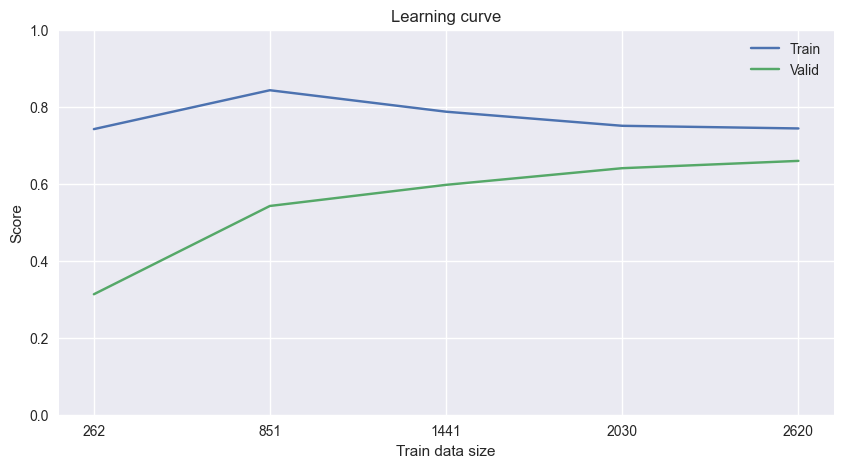

In [39]:
#Визуализируем кривую обучения
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим кривую обучения по метрикам на тренировочных фолдах
ax.plot(train_sizes, train_scores_mean, label='Train')
#Строим кривую обучения по метрикам на валидационных фолдах
ax.plot(train_sizes, valid_scores_mean, label='Valid')
#Даём название графику и подписи осям
ax.set_title('Learning curve')
ax.set_xlabel('Train data size')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси абсцисс
ax.xaxis.set_ticks(train_sizes)
#Устаналиваем диапазон оси ординат
ax.set_ylim(0, 1)
#Отображаем легенду
ax.legend();

Видно, что в процессе увеличения количества наблюдений в обучающем наборе данных, метрики на тренировочной и валидационной выборках постепенно приближаются друг к другу, то есть уменьшается разброс (variance).

На финальном этапе, при использовании всех 2 620 наблюдений из обучающей выборки, разница в показателях между тренировочной и валидационной выборками всё ещё присутствует, однако эту разницу можно принять как случайную.

In [40]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()


#### Примеры

In [41]:
#Создаём список из моделей
models = [
    linear_model.LogisticRegression(
        max_iter=1000, #количество итераций на сходимость
        random_state=42, #генератор случайных чисел
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        max_depth=7, #максимальная глубина
        min_samples_leaf=5, #минимальное число объектов в листе
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
    tree.DecisionTreeClassifier(
        criterion='entropy', #критерий информативности
        random_state=42, #генератор случайных чисел 
        class_weight='balanced' #веса классов
    ),
]

Наконец, построим кривые обучения для каждой из моделей. Для этого заранее создадим k-fold-кросс-валидатор со стратификацией на пять фолдов. Создадим фигуру с тремя координатными плоскостями. Реализуем цикл по составленному списку из моделей и их индексам (они нам понадобятся для отображения на соответствующих координатных плоскостях). Внутри цикла будем вызывать нашу функцию plot_learning_curve():

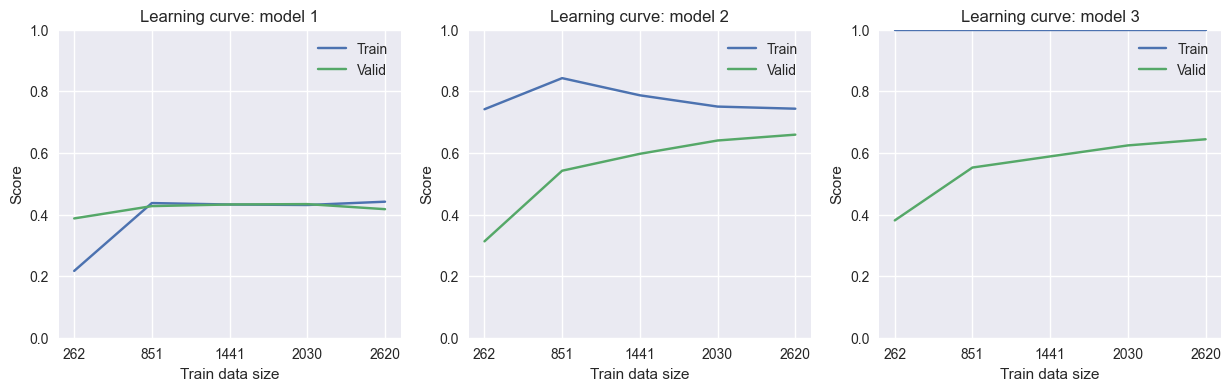

In [42]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X, y, skf, ax=axes[i], title=f'model {i+1}')
